# Projekt: Erkennung von Spurmarkierungen
In diesem Projekt sollen Spurmarkierungen in zwei bestehenden Datensätzen erkannt werden: 
1. Udacity Nanodegree "Self-Driving Car Engineer" (https://www.udacity.com/course/self-driving-car-engineer-nanodegree--nd0013)
2. KITTI-Datensatz zur Erkennung von Spurmarkierungen (http://www.cvlibs.net/datasets/kitti/eval_road.php)

In [1]:
import cv2 as cv
from matplotlib import pyplot as plt
import numpy as np
import os
import glob

In [2]:
def get_sample_image(name='image008.jpg'):
    return cv.cvtColor(cv.imread('./img/Udacity/' + name), cv.COLOR_BGR2RGB)

# Kamerakalibrierung
Die vorhandenen Bilder sind aufgrund der Linsen- und Kameraeigenschaften verzerrt. Entzerren Sie die Bilder mithilfe der Kamerakalibrierungsroutinen von OpenCV (https://docs.opencv.org/4.5.3/dc/dbb/tutorial_py_calibration.html) und den aufgezeichneten Bildern.

In [3]:
def calibrate_camera(images, nx, ny, show_corners=False):
    """Get camera calibration parameters from a set of images.

    Args:
        images (array of images): array of the images used to calibrate
        nx (int): number of chess corners in x direction
        ny (int): number of chess corners in y direction
        show_corners (bool, optional): show images with the corners included. Defaults to False.

    Returns:
        double: return values of cv.calibrateCamera
        ??: camera matrix
        ??: distortion coefficients
        ??: rotation vectors
        ??: translation vectors
    """
    # termination criteria
    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d point in real world space
    imgpoints = [] # 2d points in image plane.
    
    for fname in images:
        img = cv.imread(fname)
        gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

        # Find the chess board corners
        ret, corners = cv.findChessboardCorners(gray, (nx,ny), None)
        # If found, add object points, image points (after refining them)
        if ret == True:
            objpoints.append(objp)
            corners2 = cv.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
            imgpoints.append(corners)
            # Draw and display the corners
            
            img_d = cv.drawChessboardCorners(img, (nx,ny), corners2, ret)
            if show_corners:
                plt.imshow(img_d)
                plt.title(fname)
                plt.show()

    ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    return ret, mtx, dist, rvecs, tvecs

In [4]:
images = glob.glob('./img/Udacity/calib/calibration*.jpg')
_, mtx, dist, _, _ = calibrate_camera(images, 9, 6, show_corners=False)

# Undistort image
Hier wird das durch die Kamera verzerrte Bild, entzerrt

In [5]:
def undistort(image):
    """Undistorts an image using the camera calibration parameters.

    Args:
        image (OpenCV2 Image): image to undistort
        mtx (??): camera calibration matrix
        dist (??): ???

    Returns:
        OpenCV2 Image: undistorted image
    """
    return cv.undistort(image, mtx, dist, None, mtx)

#### Undistort single image

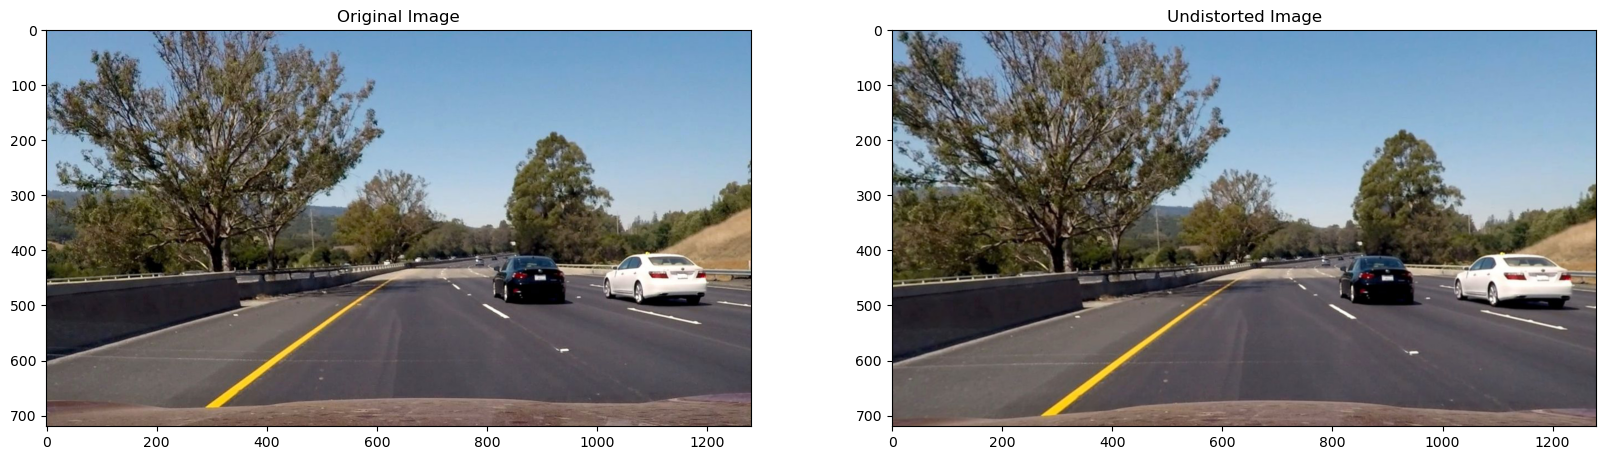

In [6]:
sample_image = get_sample_image()
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(sample_image)
plt.title('Original Image')

plt.subplot(1,2,2)
undistorted_image = undistort(sample_image)
plt.imshow(undistorted_image)
plt.title('Undistorted Image')
plt.show()

# Perspektivtransformation
Hier wird das reale Bild in ein Bird's Eye Bild der Straße transformiert

#### Warp method

In [7]:
def warp(image):
    """Warp an image to a top-down view.

    Args:
        image (OpenCV2 Image): the image to get the top-down view of

    Returns:
        OpenCV2 Image: the top-down view of the image
        ??: the transformation matrix
        ??: the inverse transformation matrix
    """
    img_size = (image.shape[1], image.shape[0]) # width x height
    offset = 200 # pixels
    src = np.float32([(701 ,459),  #top right
                      (1055,680),  #bottom right
                      (265 ,680),  #bottom left
                      (580 ,459)]) #top left

    # point array dst - destintation points close to source points in a rectangle
    
    dst = np.float32([(img_size[0]-offset,0), #top right
                      (img_size[0]-offset,img_size[1]), #bottom right
                      (img_size[0]-img_size[0]+offset,img_size[1]), #bottom left
                      (img_size[0]-img_size[0]+offset,0)]) #top left

    # use cv.getPerspectiveTransform() to get M, the transform matrix
    M = cv.getPerspectiveTransform(src, dst)
    
    # use.cv.getPerspectiveTransform() to get Minv, the inverse transform matrix
    Minv = cv.getPerspectiveTransform(dst, src)
    
    # use cv.warpPerspective() to warp your image to a top-down view
    warped = cv.warpPerspective(image, M, img_size)

    return warped, M, Minv

#### Visualize Points used for transform

(1280, 720)


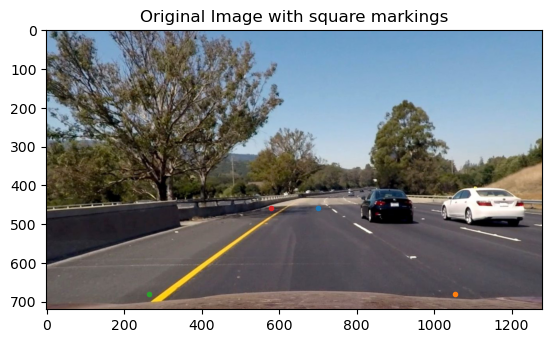

In [8]:
# verwendete Punkte visualisieren
sample = get_sample_image()
undistorted = undistort(sample)
img_size = (undistorted.shape[1], undistorted.shape[0]) # width x height

plt.imshow(undistorted)
plt.title('Original Image with square markings')
plt.plot(701,459, '.') #top right
plt.plot(1055,680, '.') #bottom right
plt.plot(265,680, '.') #bottom left
plt.plot(580,459, '.') #top left

print(img_size)

#### Warp Single Image

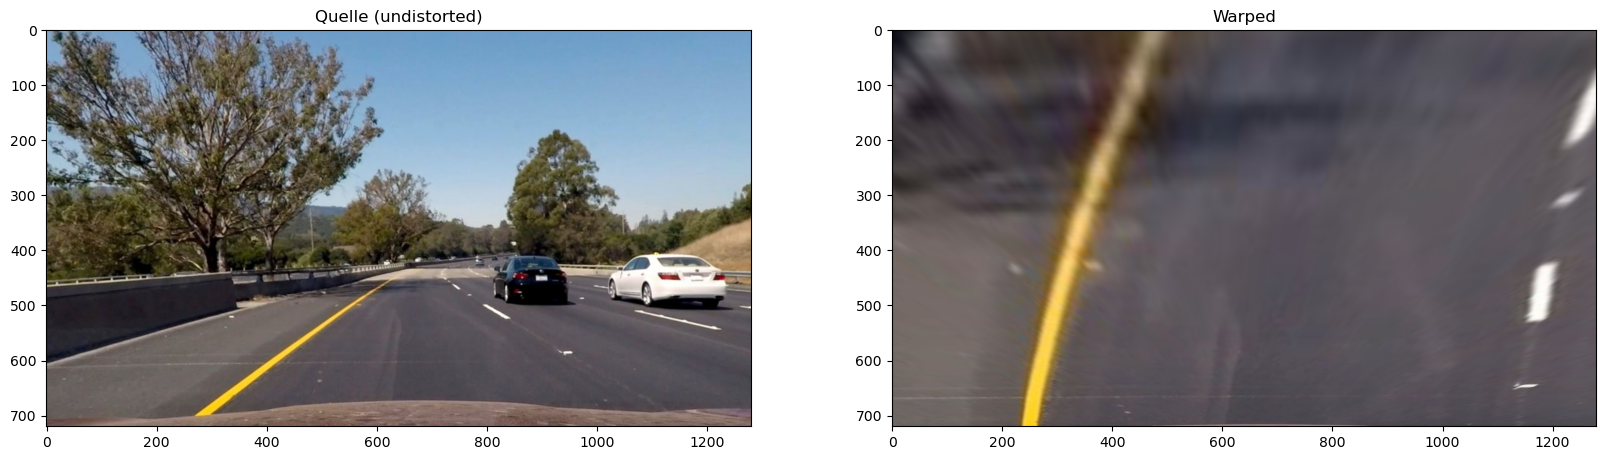

In [9]:
# einlesen eines Beispielbildes
sample = get_sample_image()
undistorted = undistort(sample)

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(undistorted)
plt.title('Quelle (undistorted)')

warped, _, _  = warp(undistorted_image)

plt.subplot(1,2,2)
plt.imshow(warped)
plt.title('Warped')
plt.show()

# Filter for lane markings v2
Hier wird aus dem bird's eye view bild die Spurmarkierung rausgefiltert

In [10]:
def extract_lab_color_spaces(uwimg):
    unwarped_LAB = cv.cvtColor(uwimg, cv.COLOR_RGB2Lab)
    unwarp_L = unwarped_LAB[:,:,0]
    unwarp_A = unwarped_LAB[:,:,1]
    unwarp_B = unwarped_LAB[:,:,2]
    
    return unwarp_L, unwarp_A,unwarp_B

# Extract H,S, and L color channels from HLS color space.
def extract_hls_color_spaces(uwimg):
    unwarp_HLS = cv.cvtColor(uwimg, cv.COLOR_RGB2HLS)
    unwarp_HLS_H = unwarp_HLS[:, :, 0]
    unwarp_HLS_L = unwarp_HLS[:, :, 1]
    unwarp_HLS_S = unwarp_HLS[:, :, 2]
    
    return unwarp_HLS_H,unwarp_HLS_L,unwarp_HLS_S

# Use exclusive lower bound (>) and inclusive upper (<=)
def hls_l_nomalize(img, thresh=(220, 255)):
    """
    This is used to nomalize HLS L color channel
    """
    # 1) Convert to HLS color space
    _,hls_l,_ = extract_hls_color_spaces(img)
    hls_l = hls_l*(255/np.max(hls_l))
    # 2) Apply a threshold to the L channel
    binary_output = np.zeros_like(hls_l)
    binary_output[(hls_l > thresh[0]) & (hls_l <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return binary_output

def lab_b_nomalize(unwarped_img, thresh=(190,255)):
    """
    This is used to LAB B color channel
    """
    _,_,lab_b = extract_lab_color_spaces(unwarped_img)
    # don't normalize if there are no yellows in the image
    if np.max(lab_b) > 175:
        lab_b = lab_b*(255/np.max(lab_b))
    # 2) Apply a threshold to the L channel
    binary_output = np.zeros_like(lab_b)
    binary_output[((lab_b > thresh[0]) & (lab_b <= thresh[1]))] = 1
    # 3) Return a binary image of threshold result
    return binary_output

def filter_lanes2(image):
    # HLS L-channel Threshold (using default parameters)
    img_hls_L = hls_l_nomalize(image)

    # Lab B-channel Threshold (using default parameters)
    img_lab_B = lab_b_nomalize(image)
    
    # Combine HLS and Lab B channel thresholds
    combined = np.zeros_like(img_lab_B)
    combined[(img_hls_L == 1) | (img_lab_B == 1)] = 1

    # reduce lines to 1px width
    kernel = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])
    perwitt = cv.filter2D(combined, -1, kernel)
    threshold = cv.threshold(perwitt, 0, 255, cv.THRESH_BINARY)[1]
    
    return threshold

#### Filter single image

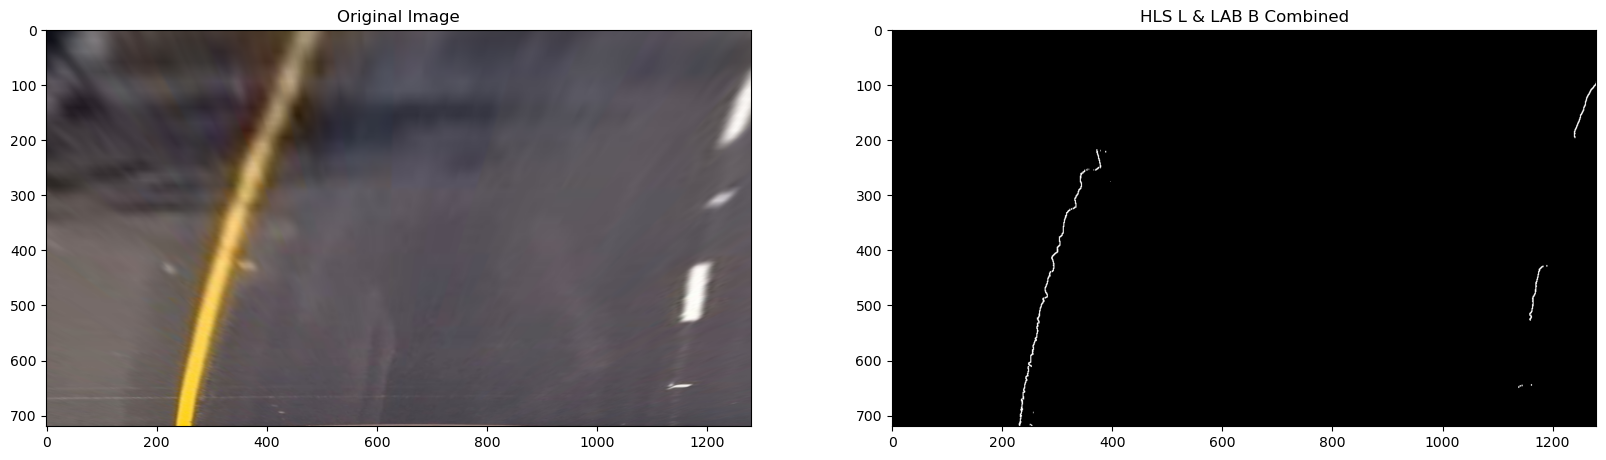

In [11]:
sample = get_sample_image()
undistorted = undistort(sample)
warped, _, _ = warp(undistorted)

# Plot the result
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(warped)
plt.title('Original Image')


filtered = filter_lanes2(warped)

plt.subplot(1,2,2)
plt.imshow(filtered, cmap='gray')
plt.title('HLS L & LAB B Combined')
plt.show()

# Test with all images (v2)
Hier wird für alle Screenshots der Filter getestet

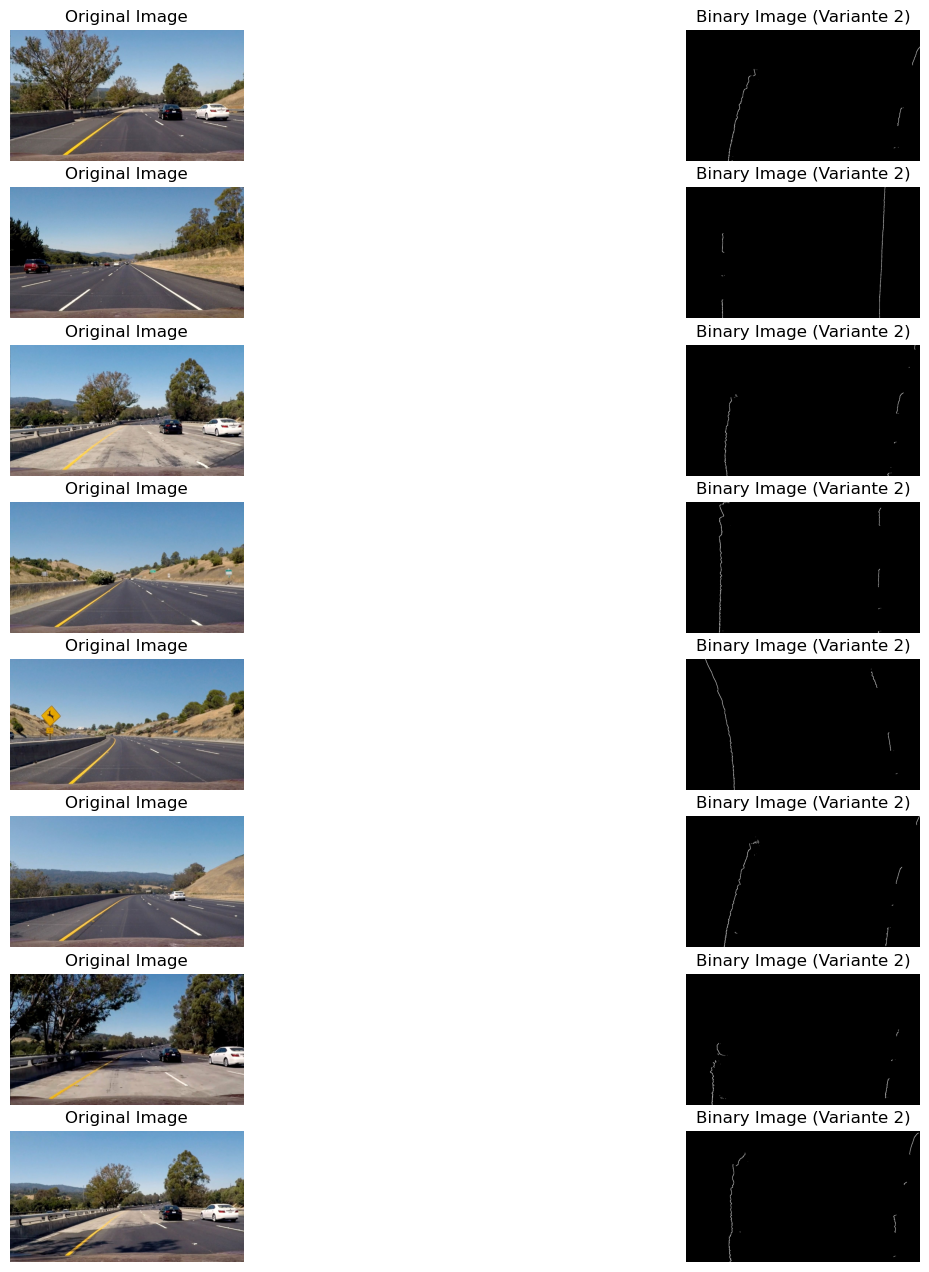

In [12]:
# Make a list of example images
images = glob.glob('./img/Udacity/*.jpg')
                                          
# Set up plot
fig, axs = plt.subplots(len(images), 2, figsize=(16, 16))
# fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
                  
i = 0
for image in images:
    img = cv.imread(image)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    undistorted = undistort(img)
    warped, _, _ = warp(undistorted)

    img_bin2 = filter_lanes2(warped)

    axs[i].imshow(img)
    axs[i].axis('off')
    axs[i].set_title("Original Image",fontsize=12)
    i += 1
    axs[i].imshow(img_bin2, cmap='gray')
    axs[i].axis('off')
    axs[i].set_title("Binary Image (Variante 2)",fontsize=12)
    i += 1

# Curve fitting

## Krümmung herausfinden

In [13]:
def find_lane_points(image):
    width = image.shape[1]
    x_left = []
    y_left = []
    x_right = []
    y_right = []
    for y, x in np.argwhere(image > 0):
        if x < width/2:
            x_left.append(x)
            y_left.append(y)
        else: 
            x_right.append(x)
            y_right.append(y)

    return x_left, y_left, x_right, y_right

In [14]:
def fit_polynomial(x_coordinates, y_coordinates):
    """Fit a second order polynomial to the given coordinates.

    Args:
        x_coordinates (int[]): x coordinates of the lane points
        y_coordinates (int[]): y coordinates of the lane points

    Returns:
        float[]: array of polynomial coefficients (length 3)
    """
    return np.polyfit(y_coordinates, x_coordinates, 2)

#### Test single image

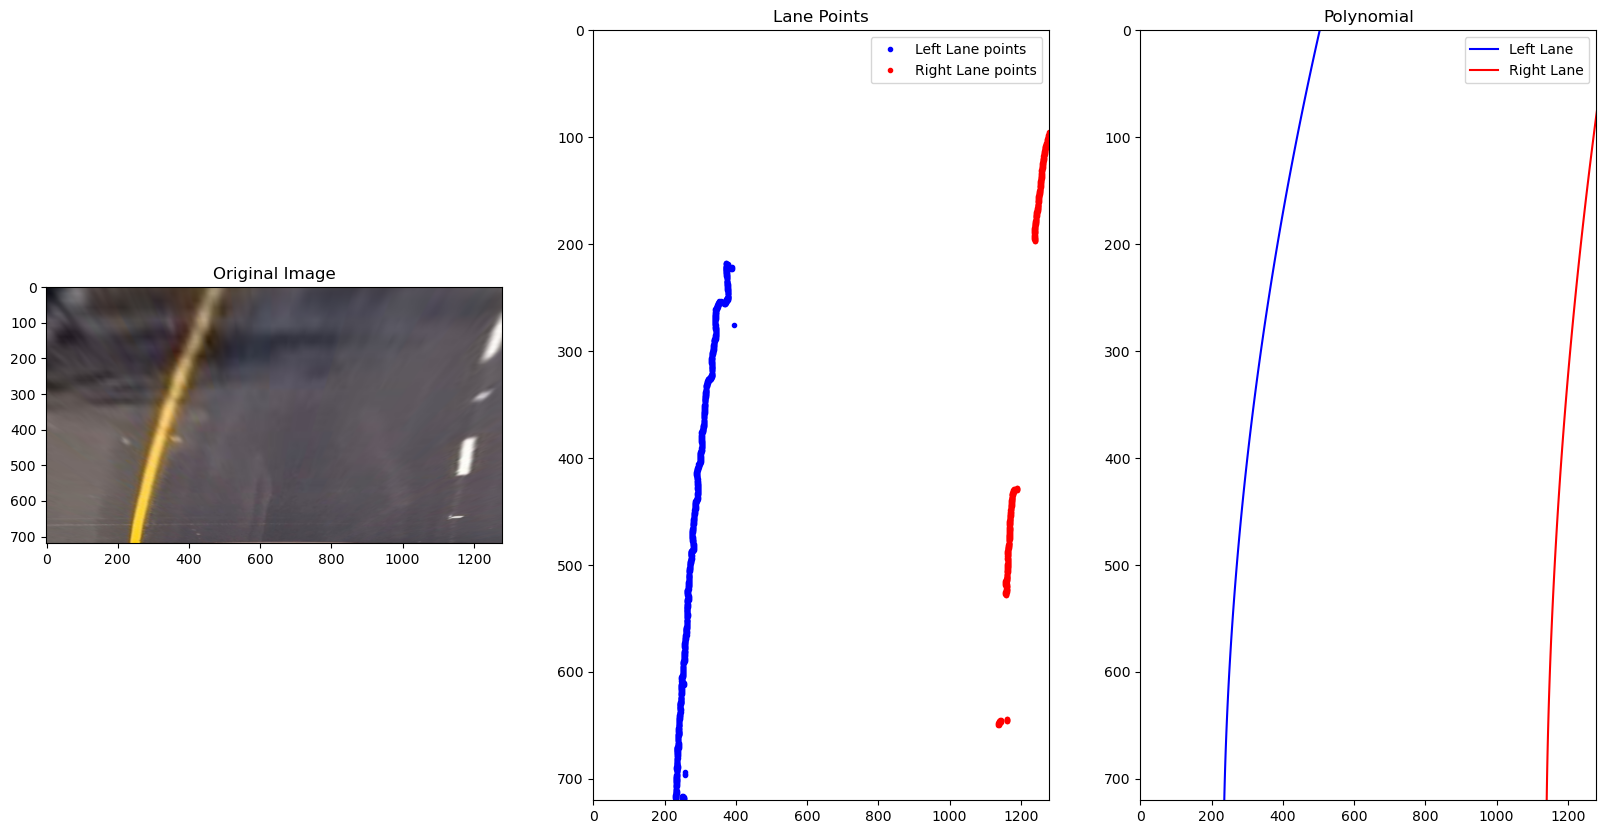

In [15]:
sample = get_sample_image()
undistorted = undistort(sample)
warped, _, _ = warp(undistorted)
filtered = filter_lanes2(warped)
x_left, y_left, x_right, y_right = find_lane_points(filtered)
w_left = fit_polynomial(x_left, y_left)
w_right = fit_polynomial(x_right, y_right)

height, width = filtered.shape

# Warped image
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(warped)
plt.title('Original Image')

# Points
plt.subplot(1,3,2)
plt.xlim(0, width)
plt.ylim(height, 0)
plt.plot(x_left, y_left, '.', color='blue', label='Left Lane points')
plt.plot(x_right, y_right, '.', color='red', label='Right Lane points')
plt.legend()
plt.title('Lane Points')

# Polynomial
x_scale = np.linspace(0, height, 100)

y_left = np.poly1d(w_left)
y_right = np.poly1d(w_right)

plt.subplot(1,3,3)
plt.xlim(0, width)
plt.ylim(height, 0)
plt.title('Polynomial')
plt.plot(y_left(x_scale),x_scale,label='Left Lane', color='blue')
plt.plot(y_right(x_scale),x_scale,label='Right Lane', color='red')
plt.legend()
plt.show()

# Curve & Lane aufmalen

In [16]:
def draw_lane(height, width, w_left, w_right):
    """Draw the lane on a black image.

    Args:
        height (int): height of the image
        width (int): width of the image
        w_left (float[]): polynomial coefficients of the left lane
        w_right (float[]): polynomial coefficients of the right lane

    Returns:
        OpenCV2 Image: Image with drawn lane and lane markings
    """
    lanes = np.zeros((height,width,3), np.uint8)

    x_scale = np.linspace(0, height, 100)
    y_left = np.polyval(w_left, x_scale)
    y_right = np.polyval(w_right, x_scale)

    left_points = (np.asarray([y_left, x_scale]).T).astype(np.int32)
    right_points = (np.asarray([y_right, x_scale]).T).astype(np.int32)

    cv.polylines(lanes, [left_points], False, (18, 102, 226), thickness=15)
    cv.polylines(lanes, [right_points], False, (18, 102, 226), thickness=15)
    
    spur = np.concatenate((left_points, right_points[::-1]))
    cv.fillPoly(lanes, np.int32([spur]), (0,255,0))

    return lanes

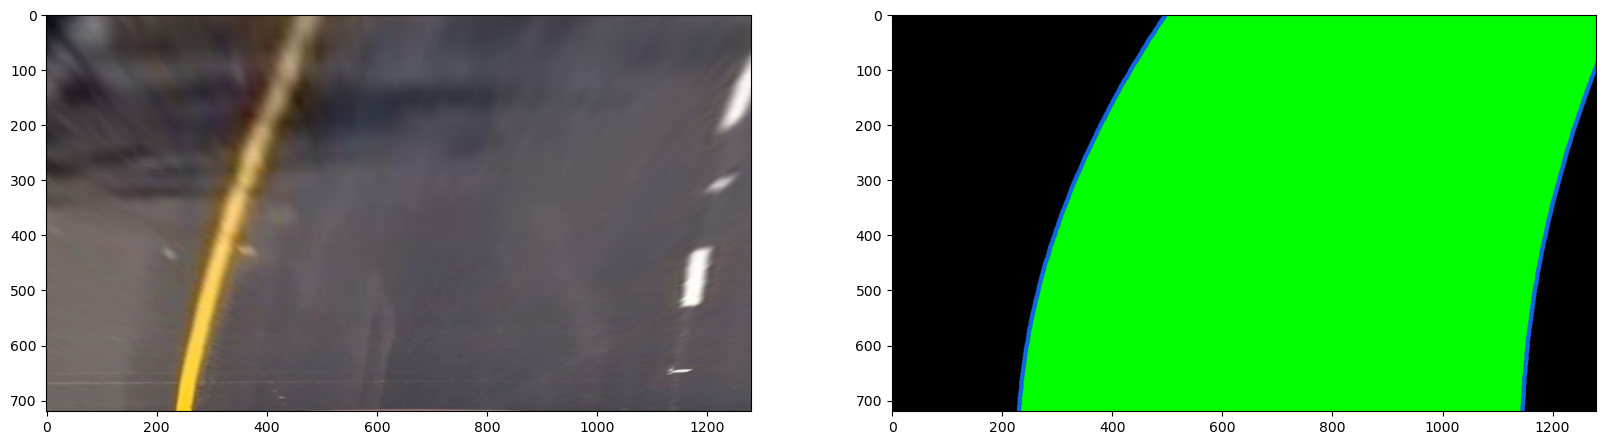

In [17]:
sample = get_sample_image()
undistorted = undistort(sample)
warped, _, _ = warp(undistorted)
filtered = filter_lanes2(warped)

x_left, y_left, x_right, y_right = find_lane_points(filtered)
w_left = fit_polynomial(x_left, y_left)
w_right = fit_polynomial(x_right, y_right)


plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(warped)

width, height, _ = warped.shape
lanes = draw_lane(width, height, w_left, w_right)

plt.subplot(1,2,2)
plt.imshow(lanes)
plt.show()

# Krümmung finden

In [18]:
def get_radius(w):
    """Calculate the radius of the lane.

    Args:
        w (float[]): polynomial coefficients of the lane

    Returns:
        float: radius of the lane
    """
    # TODO: muss das hier nicht width sein?: nein wil hier jemand width und height vertauscht hat
    return ((1 + (2*w[0]*height + w[1])**2)**1.5) / np.absolute(2*w[0])

def get_kruemmung(w_left, w_right):
    """Calculate the curvature of the lane. Averages the curvature of the left and right lane.

    Args:
        w_left (float[]): polynomial coefficients of the left lane
        w_right (float[]): polynomial coefficients of the right lane

    Returns:
        float: curvature of the lane
    """
    rad_left = get_radius(w_left)
    rad_right = get_radius(w_right)
    return (rad_left + rad_right) / 2
    

# Spur zusammenbauen

In [19]:
def unwarp(img, M, Minv):
    warped = cv.warpPerspective(img, Minv, (img.shape[1], img.shape[0]), flags=cv.INTER_LINEAR)
    return warped

In [20]:
def overlay(original, overlay, opacity=0.5):
    """
    This function overlays the detected lane area onto the original image
    """
    # Make sure the overlay and original images are in the same size
    assert original.shape == overlay.shape
    
    # Create a copy of the original image
    result = original.copy()
    
    # Overlay the mask onto the original image
    result = cv.addWeighted(original, 1.0, overlay, opacity, 0)
    
    return result

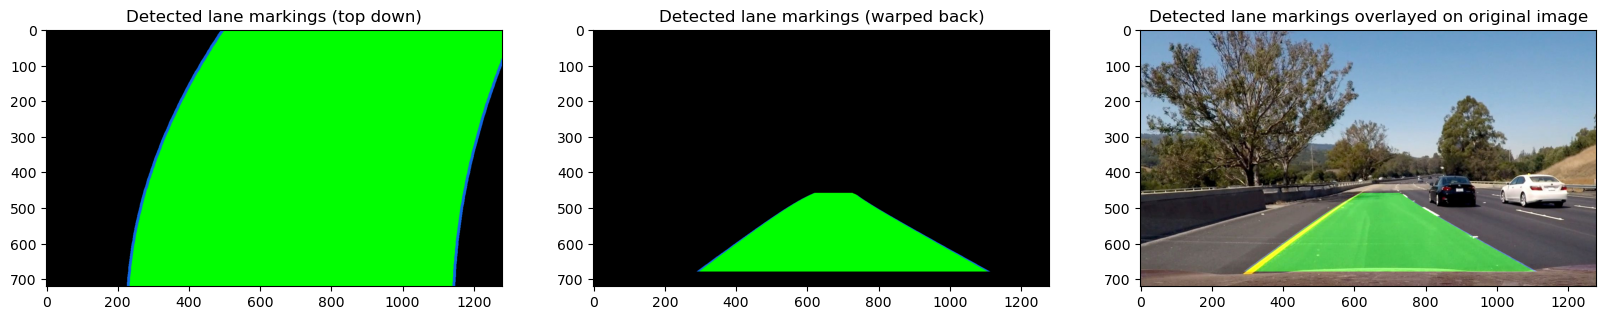

In [21]:
sample = get_sample_image()
undistorted = undistort(sample)
warped, M, Minv = warp(undistorted)

x_left, y_left, x_right, y_right = find_lane_points(filtered)
w_left = fit_polynomial(x_left, y_left)
w_right = fit_polynomial(x_right, y_right)

width, height, _ = warped.shape

lanes = draw_lane(width, height, w_left, w_right)
unwarped = unwarp(lanes, M, Minv)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(lanes)
plt.title("Detected lane markings (top down)")

plt.subplot(1,3,2)
plt.imshow(unwarped)
plt.title("Detected lane markings (warped back)")

plt.subplot(1,3,3)
plt.imshow(overlay(sample, unwarped))
plt.title("Detected lane markings overlayed on original image")
plt.show()

# Zusatzaufgabe: Objekterkennung und -visualisierung
- Objekte im Bild erkennen und visualisieren (z.B. weitere Fahrzeuge, Motorräder, etc.)
- ist deaktivierbar und zählt nicht in FPS-Berechnung ein.
- Input = undistorted image

In [22]:
def detect_objects(image):
    """Detect cars and motorcycles in the image.

    Args:
        image (OpenCV2 Image): Image to process

    Returns:
        OpenCV2 Image: Image with detected objects
    """

    # load the cascade classifiers
    car_cascade = cv.CascadeClassifier('cascade_cars.xml')
    motorcycle_cascade = cv.CascadeClassifier('cascade_motorcycles.xml')

    # perform the detection
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    # cars = car_cascade.detectMultiScale(gray, 1.1, 2, 0, (100, 100))  # best performing on KITTI dataset
    cars = car_cascade.detectMultiScale(gray, 1.1, 3, 0, (70, 70))      # best performing on Udacity dataset
    motorcycles = motorcycle_cascade.detectMultiScale(gray, 1.1, 2)

    # draw the rectangles: cars in blue, motorcycles in green
    for (x,y,w,h) in cars:
        cv.rectangle(image,(x,y),(x+w,y+h),(0,0,255),2)
    for (x,y,w,h) in motorcycles:
        cv.rectangle(image,(x,y),(x+w,y+h),(0,255,0),2)
    
    return image

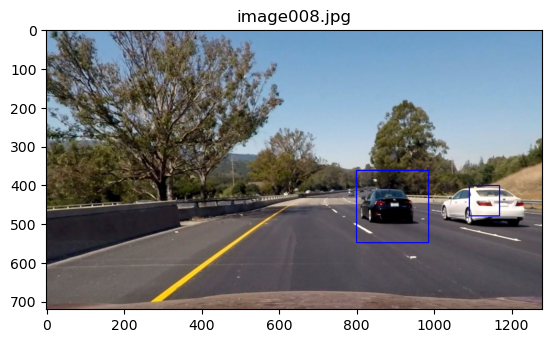

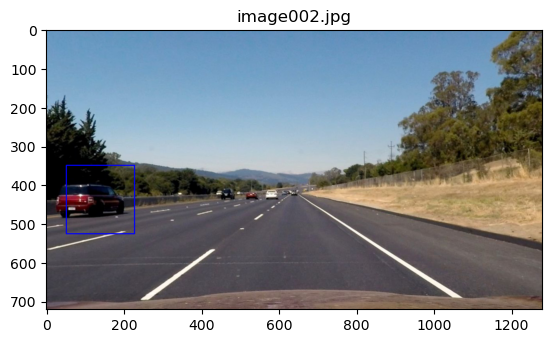

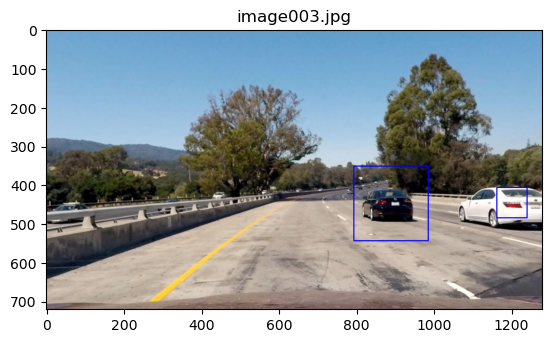

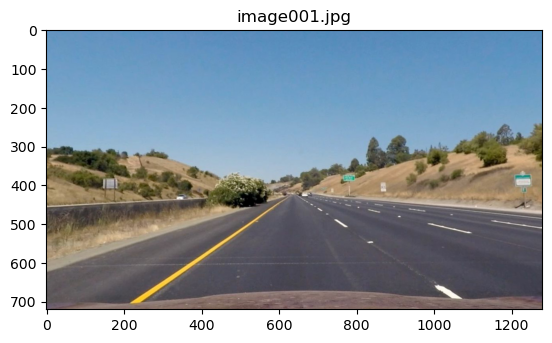

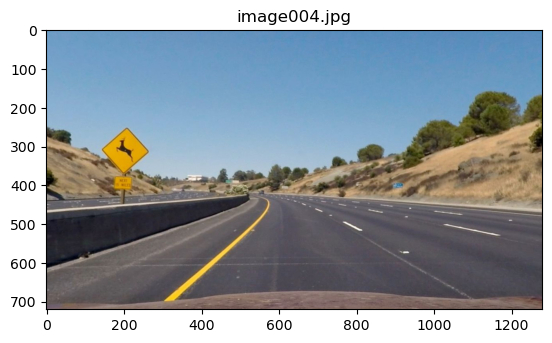

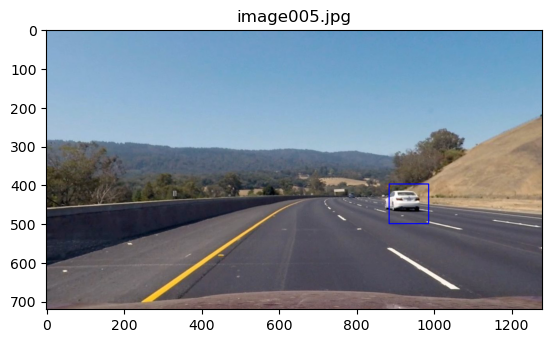

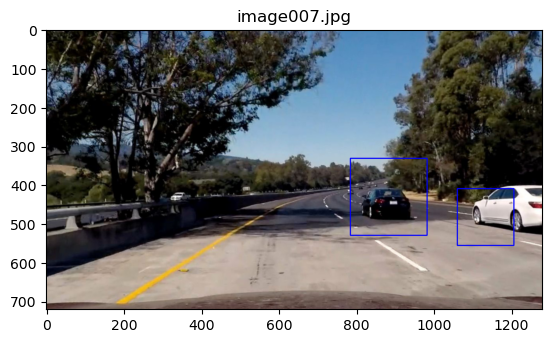

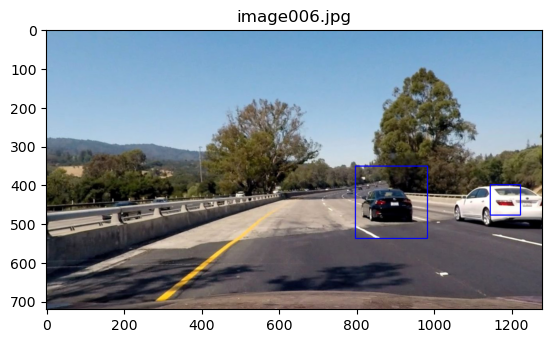

In [23]:
# folder = 'KITTI'
folder = 'Udacity'
folder_dir = os.path.join(os.getcwd(), 'img', folder)
for imgfile in os.listdir(folder_dir):
    if (imgfile.endswith(".jpg")):
        sample = cv.cvtColor(cv.imread(os.path.join(os.getcwd(), 'img', folder, imgfile)), cv.COLOR_BGR2RGB)
        undistorted = undistort(sample)
        image_detected = detect_objects(undistorted)
        plt.imshow(image_detected)
        plt.title(imgfile)
        plt.show()

# Komplette Pipeline
Hier ist die Definition der kompletten Verarbeitungspipeline für jedes Frame im Video

In [24]:
def pipeline(image, object_detection=True, show_debug=False):
    """Pipeline for lane and object detection.

    Args:
        image (OpenCV2 Image): Image to process
        object_detection (bool, optional): Whether to detect objects. Defaults to True.
        show_debug (bool, optional): Whether to show debug images in the Jupyter Notebook. Defaults to False.

    Returns:
        OpenCV2 Image: Image with detected lane markings
    """
    # undistort
    undistorted = undistort(image)

    # Persfective transform
    warped, M, Minv = warp(undistorted)

    # Filter lanes
    filtered = filter_lanes2(warped)

    # Spurpunkte finden
    x_left, y_left, x_right, y_right = find_lane_points(filtered)
    w_left = fit_polynomial(x_left, y_left)
    w_right = fit_polynomial(x_right, y_right)

    # Kurze einzeichnen
    width, height = filtered.shape
    lanes = draw_lane(width, height, w_left, w_right)

    # zurück-warpen
    unwarped = unwarp(lanes, M, Minv)

    # Überlagern
    result = overlay(undistorted, unwarped)

    # Radius berechnen
    krumm = get_kruemmung(w_left, w_right)
    cv.putText(result, "Radius: {:.2f}".format(krumm), (50, 50), cv.FONT_HERSHEY_TRIPLEX, 1, (255, 255, 255), 2)

    # Objekte erkennen
    if object_detection:
        result = detect_objects(result)

    # Debugging 
    if show_debug:
        plt.imshow(undistorted)
        plt.title("Undistorted image")
        plt.show()

        # Persfective transform
        plt.imshow(warped)
        plt.title("Warped image")
        plt.show()

        # Filter lanes
        plt.imshow(filtered, cmap='gray')
        plt.title("Filtered image")
        plt.show()

        # Spurpunkte finden
        plt.imshow(lanes)
        plt.title("Spurmarkierungen")
        plt.show()

        # zurück-warpen
        plt.imshow(unwarped)
        plt.title("Spur zurücktransformiert")
        plt.show()

        # Überlagern
        plt.imshow(result)
        plt.title("Spur überlagert")
        plt.show()

        # Radius berechnen
        print("Krümmung: ", krumm)

        # Objekte erkennen
        if object_detection:
            plt.imshow(result)
            plt.title("Objekte erkannt")
            plt.show()

    return result

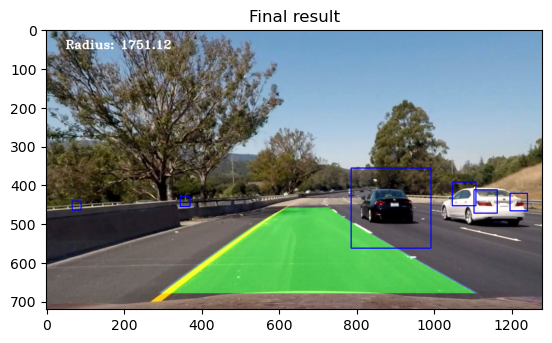

In [80]:
sample = get_sample_image()
result = pipeline(sample)
plt.imshow(result)
plt.title("Final result")
plt.show()

# Timing
Hier wird getestet, wie schnell die Verarbeitung für ein Frame ist

Frametime:  0.08603501319885254
est. FPS:  11.62317483102725


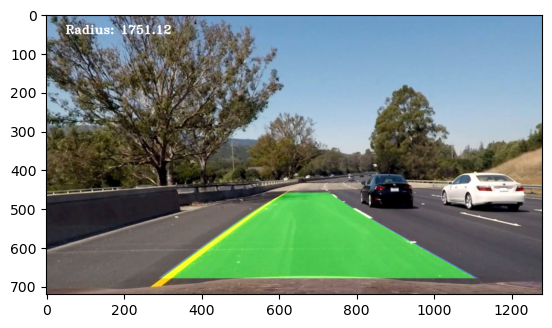

In [32]:
import time

sample = get_sample_image()

start = time.time()

result = pipeline(sample, object_detection=False)  # object detection soll nicht in die FPS-Berechnung einfließen

diff = time.time() - start

print('Frametime: ', diff)
print('est. FPS: ', 1/diff)

plt.imshow(result, cmap='gray')
plt.show()

# Video-Verarbeitung

In [31]:
input_video = cv.VideoCapture('img/Udacity/project_video.mp4')
 
# Check if camera opened successfully
if (input_video.isOpened()== False): 
  print("Error opening video stream or file")
else:
  v_width  = int(input_video.get(cv.CAP_PROP_FRAME_WIDTH))
  v_height = int(input_video.get(cv.CAP_PROP_FRAME_HEIGHT))
  fps = input_video.get(cv.CAP_PROP_FPS)
  print("Video size: ", v_width, "x", v_height)
  fourcc = cv.VideoWriter_fourcc(*'X264')
  output_video = cv.VideoWriter('output.mp4', fourcc, fps, (v_width, v_height))

 
# Read until video is completed
while(input_video.isOpened()):
  # Capture frame-by-frame
  ret, frame = input_video.read()
  if ret == True:
    cv.startWindowThread()

    # covert to rgb as pipeline expects rgb
    frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB)

    # EIGENTLICHE PIPELINE
    output = pipeline(frame)

    # convert back to bgr for saving video
    output = cv.cvtColor(output, cv.COLOR_RGB2BGR)
 
    # Display the resulting frame
    cv.imshow('Frame', output)
    
    # show single frame in notebook
    # plt.imshow(output[:,:,::-1])
    # plt.show()
    # break

    # write frame to video
    output_video.write(output)
 
    # Press Q on keyboard to  exit
    if cv.waitKey(25) & 0xFF == ord('q'):
      break
 
  # Break the loop
  else: 
    break
 
# When everything done, release the video capture object
input_video.release()
output_video.release()

# Closes all the frames
cv.destroyAllWindows()
cv.waitKey(1)

[ WARN:0@185.583] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_506zufg7xt/croots/recipe/opencv-suite_1664548331847/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@185.583] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_506zufg7xt/croots/recipe/opencv-suite_1664548331847/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_506zufg7xt/croots/recipe/opencv-suite_1664548331847/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'




Video size:  1280 x 720


[ WARN:0@185.850] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_506zufg7xt/croots/recipe/opencv-suite_1664548331847/work/modules/videoio/src/cap_gstreamer.cpp (2180) open OpenCV | GStreamer warning: cannot link elements
